## Import modules

In [1]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
# numpy is used for generating, storing, and plotting data
import numpy as np
# zfit will be used for the parameter estimation in the following
import zfit
import uproot
import pandas

# in order to visualise the results of the computation, we use matplotlib
import matplotlib as mpl
if os.path.exists('lhcbStylerc'):
    mpl.rc_file('lhcbStylerc') # some plotting presets i usually use, you can find them in the git-repo
import socket
#if 'jupyter-schmitse-' in socket.gethostname():
#    mpl.rcParams['text.usetex'] = False # no latex on binder
    
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.LHCb2)
#plt.rcParams['text.usetex'] = True
# for histograms boost has an easy api and is very fast
import hist
# for statistical distributions we can use a lot from scipy
from scipy import stats

### Open ntuple

In [2]:
branches_we_want = ["C_M","Xicc_M_DTF_Lc_PV","Pi_M","C_M_DTF_Xicc_PV","C_KaonDTF_C_M","Xicc_TMVA_BDTXicc","BDT","BDTG","MLP"] 

#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-WS-Run2-Lc-Loose-clone-duplicate-Loose-MVA.root"
with uproot.open(path) as file:
    Xiccp_WS = file['DecayTree']
    Xiccp_WS_Loose_data = Xiccp_WS.arrays(expressions = branches_we_want, library='pd')
    

#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Omegaccpst-WS-Run2-Lc-Loose-clone-duplicate-Loose-MVA.root"
with uproot.open(path) as file:
    Omegaccp_WS = file['DecayTree']
    Omegaccp_WS_Loose_data = Omegaccp_WS.arrays(expressions = branches_we_want, library='pd')  
    
    
#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-RS-Run2-Lc-Loose-clone-duplicate-Loose-MVA.root"
with uproot.open(path) as file:
    Xiccp_RS = file['DecayTree'] 
    Xiccp_RS_Loose_data = Xiccp_RS.arrays(expressions = branches_we_want, library='pd')
    
 
#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Omegaccpst-RS-Run2-Lc-Loose-clone-duplicate-Loose-MVA.root"
with uproot.open(path) as file:
    Omegaccp_RS = file['DecayTree']
    Omegaccp_RS_Loose_data = Omegaccp_RS.arrays(expressions = branches_we_want, library='pd')


# TIGHT

#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-WS-Run2-Lc-Loose-clone-duplicate-Tight-MVA.root"
with uproot.open(path) as file:
    Xiccp_WS = file['DecayTree']
    Xiccp_WS_Tight_data = Xiccp_WS.arrays(expressions = branches_we_want, library='pd')
    

#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Omegaccpst-WS-Run2-Lc-Loose-clone-duplicate-Tight-MVA.root"
with uproot.open(path) as file:
    Omegaccp_WS = file['DecayTree']
    Omegaccp_WS_Tight_data = Omegaccp_WS.arrays(expressions = branches_we_want, library='pd')  
    
    
#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-RS-Run2-Lc-Loose-clone-duplicate-Tight-MVA.root"
with uproot.open(path) as file:
    Xiccp_RS = file['DecayTree']
    Xiccp_RS_Tight_data = Xiccp_RS.arrays(expressions = branches_we_want, library='pd')
    
 
#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Omegaccpst-RS-Run2-Lc-Loose-clone-duplicate-Tight-MVA.root"
with uproot.open(path) as file:
    Omegaccp_RS = file['DecayTree'] 
    Omegaccp_RS_Tight_data = Omegaccp_RS.arrays(expressions = branches_we_want, library='pd')
    




## MC

In [3]:
pathOmega="/eos/lhcb/user/p/pgaigne/STEP3/Run2/Omegaccpst-MC-Run2-MCMatch-clone-duplicate.root"

thresholdOmega = 4115.1

pathXicc="/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-MC-Run2-MCMatch-clone-duplicate.root"
thresholdXicc = 3761


branches = ["Xicc_M_DTF_Lc_PV", "Lc_M", "Pi_ProbNNk", "Pi_ProbNNpi", "C_KaonDTF_K_PT", "Pi_PT", "Xicc_TMVA_BDTXicc", "C_TRUEP_E", "C_TRUEP_X", "C_TRUEP_Y", "C_TRUEP_Z"]
    
file =  uproot.open(pathOmega)
tree = file['DecayTree']
data_Omega = tree.arrays( library='pd').reset_index(level=1, drop=True).drop_duplicates(subset=['C_ETA','C_LOKI_IPCHI2'])
file.close()   


file =  uproot.open(pathXicc)
tree = file['DecayTree']
data_Xicc = tree.arrays( library='pd').reset_index(level=1, drop=True).drop_duplicates(subset=['C_ETA','C_LOKI_IPCHI2'])
file.close() 

In [4]:
zfit.settings.set_seed(1337)
gen = np.random.default_rng(seed=1337)

## Cut selection

In [5]:
Omega_SB_start, Omega_SB_end = 25, 40
Xi_SB_start, Xi_SB_end = 25, 40

Omegaccp_WS_Loose_data_cut = Omegaccp_WS_Loose_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15")
Xiccp_WS_Loose_data_cut = Xiccp_WS_Loose_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15")
Omegaccp_RS_Loose_data_cut = Omegaccp_RS_Loose_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15")
Xiccp_RS_Loose_data_cut = Xiccp_RS_Loose_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15")
Omegaccp_SB_Loose_data_cut = Omegaccp_RS_Loose_data.query(f"((Xicc_M_DTF_Lc_PV<3621-{Omega_SB_start})&(Xicc_M_DTF_Lc_PV>3621-{Omega_SB_end}))|((Xicc_M_DTF_Lc_PV>3621+{Omega_SB_start})&(Xicc_M_DTF_Lc_PV<3621+{Omega_SB_end}))")
Xiccp_SB_Loose_data_cut = Xiccp_RS_Loose_data.query(f"((Xicc_M_DTF_Lc_PV<3621-{Xi_SB_start})&(Xicc_M_DTF_Lc_PV>3621-{Xi_SB_end}))|((Xicc_M_DTF_Lc_PV>3621+{Xi_SB_start})&(Xicc_M_DTF_Lc_PV<3621+{Xi_SB_end}))")


Omegaccp_WS_Tight_data_cut = Omegaccp_WS_Tight_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & Xicc_TMVA_BDTXicc>0.17")
Xiccp_WS_Tight_data_cut = Xiccp_WS_Tight_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & Xicc_TMVA_BDTXicc>0.17")
Omegaccp_RS_Tight_data_cut = Omegaccp_RS_Tight_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & Xicc_TMVA_BDTXicc>0.17")
Xiccp_RS_Tight_data_cut = Xiccp_RS_Tight_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & Xicc_TMVA_BDTXicc>0.17")
Omegaccp_SB_Tight_data_cut = Omegaccp_RS_Tight_data.query(f"((Xicc_M_DTF_Lc_PV<3621-{Omega_SB_start})&(Xicc_M_DTF_Lc_PV>3621-{Omega_SB_end}))|((Xicc_M_DTF_Lc_PV>3621+{Omega_SB_start})&(Xicc_M_DTF_Lc_PV<3621+{Omega_SB_end}))")
Xiccp_SB_Tight_data_cut = Xiccp_RS_Tight_data.query(f"((Xicc_M_DTF_Lc_PV<3621-{Xi_SB_start})&(Xicc_M_DTF_Lc_PV>3621-{Xi_SB_end}))|((Xicc_M_DTF_Lc_PV>3621+{Xi_SB_start})&(Xicc_M_DTF_Lc_PV<3621+{Xi_SB_end}))")


In [6]:
data_Omega_cut = data_Omega.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & abs(Lc_M-2288)<18 & Pi_ProbNNk>0.1 & C_KaonDTF_K_PT>200 & Xicc_TMVA_BDTXicc>0.07")

data_Xicc_cut = data_Xicc.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & abs(Lc_M-2288)<18  & Pi_ProbNNpi>0.1 & Pi_PT>200 & Xicc_TMVA_BDTXicc>0.07")

## Omegaccp

### MC

In [7]:
mass = 4350

obs_min = mass-25
obs_max = mass+25
obs_bin_width = 1
obs_bin = int((obs_max-obs_min)/obs_bin_width)

data = data_Omega_cut.query(f"abs(C_KaonDTF_C_M-{mass})<25").C_KaonDTF_C_M

In [8]:
# parameters for signal and background shapes
mu = zfit.Parameter("mu_Omega_MC", mass, 4000, 4500)
sigma1 = zfit.Parameter("sigma1_Omega_MC", 1.5, 0.5, 50.)

sigma2 = zfit.Parameter("sigma2", 1.5, 1., 50.)
a1 = zfit.Parameter("alpha1",1.5,0.,10.)
a2 = zfit.Parameter("alpha2",6.5,0.,10.)
n1 = zfit.Parameter("n1",1.5,0.,50.)
n2 = zfit.Parameter("n2",1.5,0.,500.)
frac = zfit.Parameter("frac",0.3,0.,1.)

# using a dict for the params
def mult_dict(params):
    return np.sqrt(params["frac"] * params["sigma1"]**2 + (1-params["frac"]) * params["sigma2"]**2)

sigma = zfit.ComposedParameter('sigma_Omega_MC', mult_dict, params={"sigma1": sigma1, "sigma2": sigma2, "frac": frac})

# yields for an extended fit
n_signal = zfit.Parameter('n_signal', 100, 0, 10000)

In [9]:
obs_bkg = zfit.Space('Observable with Background', limits=(obs_min, obs_max))





# create the pdfs with the extended term for the yields
gaussian = zfit.pdf.Gauss(obs=obs_bkg, mu=mu, sigma=sigma1, name='Gaussian')
doubleCB = zfit.pdf.DoubleCB(mu=mu, sigma=sigma2, alphal=a1, nl=n1, alphar=a2, nr=n2, obs=obs_bkg, name='DoubleCB')

model_sum = zfit.pdf.SumPDF([gaussian, doubleCB], fracs=[frac])

model_ext = doubleCB.create_extended(n_signal)



# build the model as the sum of the gaussian and the exponential functions
model = model_ext

In [10]:
data_all = data.to_numpy()

data_zfit = zfit.Data.from_numpy(obs=obs_bkg, array=data_all)

# loss function is now extended unbinned NLL
nll_ext = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data_zfit)

# the minimiser
minimiser = zfit.minimize.Minuit(mode=1)

### Minimization

In [11]:
# %%
result_ext = minimiser.minimize(nll_ext)
result_ext.hesse(name='minuit_hesse')
result_ext.errors()
print(result_ext)

/afs/cern.ch/user/p/pgaigne/Starterkit22/starterkit-2022-python-and-bash-tutorial/startkitEnv/lib/python3.9/site-packages/zfit/minimizers/fitresult.py:1318: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(
/afs/cern.ch/user/p/pgaigne/Starterkit22/starterkit-2022-python-and-bash-tutorial/startkitEnv/lib/python3.9/site-packages/zfit/minimizers/fitresult.py:1341: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.errors_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of errors (which is currently the method name such as `minuit_minos`or `zfit_errors`) has changed to `errors`. Old names are still added as well for compatibility but will be remov

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.physics.DoubleCB'>  params=[alpha1, alpha2, mu_Omega_MC, n1, n2, sigma2]] data=[<zfit.core.data.Data object at 0x7f24102c67f0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ False   │ True        │ True             │ 7.3e-05 │ -5047.701   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name           value  (rounded)    minuit_hesse               errors         minuit_minos    at limit
-----------  ------------------  --------------  -------------------  -------------------  ----------
n_signal                1972.69     +/-      30  -     30   +     30  -     30   +     30       False
mu_Omega_MC             4350.07     +/-    0.06  -   0.06   +   0.06  -   0.06   +   0.06    

In [12]:
muu = float(mu)
# mu_err = result_ext.hesse()[mu]['error']

sigma.read_value()

<tf.Tensor: shape=(), dtype=float64, numpy=3.3906092991729238>

In [13]:
def plot_fit(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=obs_bin, smodel: np.ndarray=None,
             drawstyle: str='default', zmodel: zfit.pdf.BasePDF=None, title='LHCb 2016'):
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
     - zmodel: (BasePDF) for drawing submodels
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.area().numpy()

    # data in histogram over the full observable space
    histo = hist.Hist(hist.axis.Regular(nbins, *limits))
    histo.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(histo.axes.centers[0], histo.values(), 
                           xerr=histo.axes.widths[0]/2,
                           yerr=np.sqrt(histo.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)

    # define artists and labels for the legend
    artists = [art_data, art_model]
    labels = ['Data', 'Model']
    # if we want to plot the submodels of our model, we can iterate through
    # all of them and evaluate them at our basis. We will not bootstrap
    # all of their shape uncertainties though, this is just an illustration
    if hasattr(zmodel, 'get_models'):
        nmodels = len(zmodel.get_models())
        cmap = plt.get_cmap('autumn') # you can choose whatever you like. 
        norm = mpl.colors.Normalize(0, nmodels) # create a norm for the cmap
        pdfs = [(m.pdf(basis)*n_signal*frac).numpy()*area/nbins
                for m, frac in zip(zmodel.pdfs, zmodel.params.values())]
        names = [m.name.replace('_extended','') for m in zmodel.get_models()]
        labels.extend(names)
        for mdex, pdf in enumerate(pdfs):
            artists.append(ax.plot(basis, pdf, color=cmap(norm(mdex)), 
                                   linestyle='--', zorder=-1)[0])
        
    
    #ax.set_xlabel('$m_{cand}(\Xi_{cc}^{++})[MeV/c^2]$')
    ax.set_xlabel('M$(\Omega_{cc}^{**+})[MeV/c^2]$')
    ax.set_ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )');
    
    textstr = '\n'.join((
        r'$\mu_m=%.2f $ MeV/$c^2$' % (float(mu)),
        r'$\sigma_m=%.2f $  MeV/$c^2$' % (float(sigma2)),
        r'$\alpha_1=%.2f $' % (float(a1)),
        r'$\alpha_2=%.2f $' % (float(a2)),
        r'$n_1=%.2f $' % (float(n1)),
        r'$n_2=%.2f $' % (float(n2))))
    ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=24,
        verticalalignment='top')
    
    # legend and axis labels
    ax.legend(artists, labels, loc='upper left', 
              title=title, title_fontsize=20)


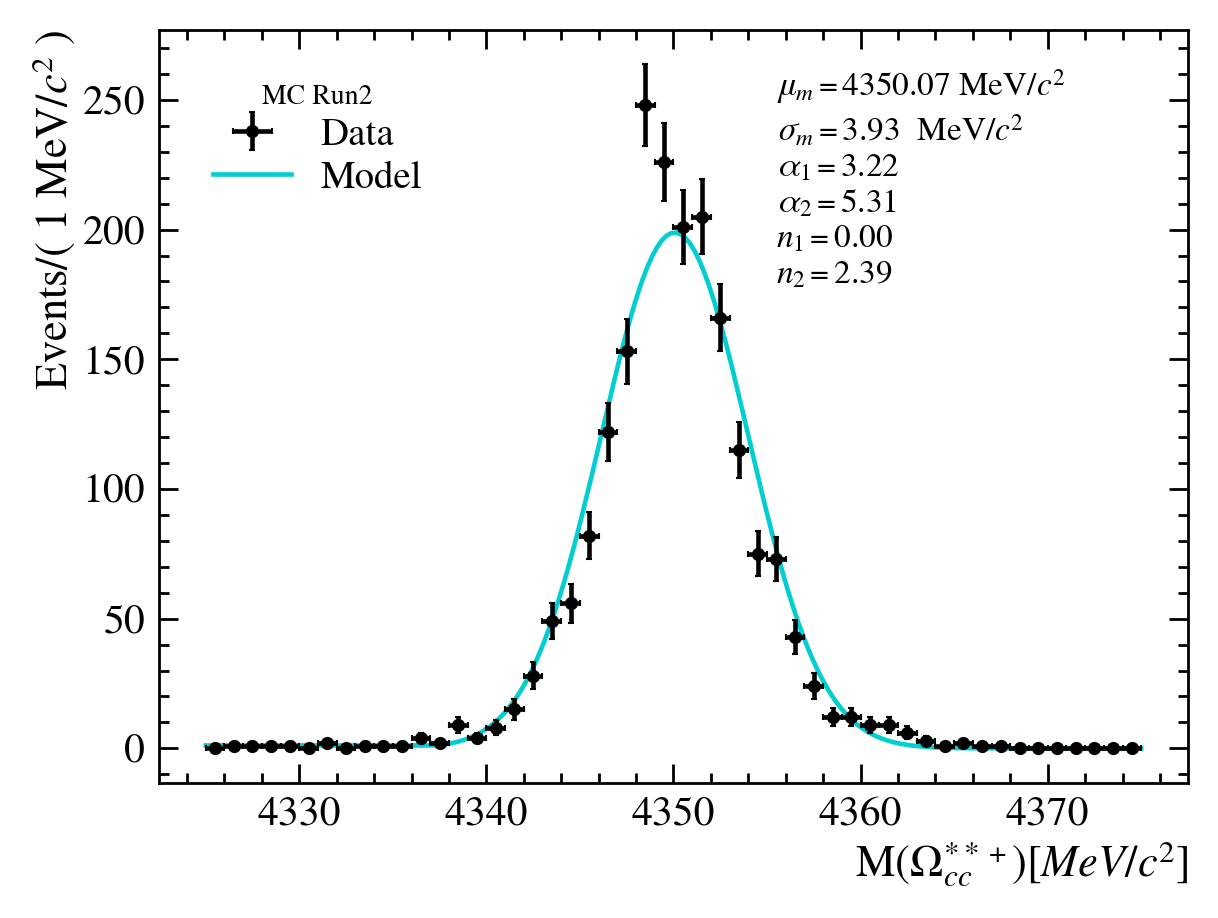

In [14]:
# the model as the sum of the individual pdfs
basis_pdf = np.linspace(obs_min, obs_max, 200)
model_pdf_np = model.pdf(basis_pdf).numpy() * (n_signal.numpy())

plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, zmodel=model, title=f'MC Run2')

## Background

In [15]:
obs_min = 0
obs_max = 500
obs_bin_width = 4
obs_bin = int((obs_max-obs_min)/obs_bin_width)

data = Omegaccp_WS_Loose_data_cut.query("MLP>0.22").C_KaonDTF_C_M - thresholdOmega

In [16]:

data_all = data.to_numpy()

# new observable and zfit data
obs_bkg = zfit.Space('Observable with Background', limits=(obs_min, obs_max))
data_zfit = zfit.Data.from_numpy(obs=obs_bkg, array=data_all)


In [17]:
from zfit import z
class MyBkg(zfit.pdf.BasePDF):

    def __init__(self, a, b, obs, extended=None, norm=None, name=None):
        params = {'a': a,  # 'mean' is the name as it will be named in the PDF, mean is just the parameter to create the PDF
                  'b': b
                  }
        super().__init__(obs=obs, params=params, extended=extended, norm=norm,
                         name=name)

    def _unnormalized_pdf(self, x):
        x = z.unstack_x(x)
        a = self.params['a']
        b = self.params['b']
        return (x**a)*z.exp(-b*x)

In [18]:
# parameters for signal and background shapes
power = zfit.Parameter("power", 0.27,0.,1.)
slope = zfit.Parameter("slope", 0.002,-0.01,0.01)

n_bkg = zfit.Parameter('n_bkg', 3000, 0, 1000000)

In [19]:


my_model = MyBkg(obs=obs_bkg, a=power, b=slope)
exponential = zfit.pdf.Exponential(obs=obs_bkg, lam=slope, name='Background')


model = my_model
# model = exponential

In [20]:
# loss function is now extended unbinned NLL
nll_ext = zfit.loss.UnbinnedNLL(model=model, data=data_zfit)

# the minimiser
minimiser = zfit.minimize.Minuit(mode=1)

### Minimization

In [21]:
result_ext = minimiser.minimize(nll_ext)
result_ext.hesse(name='minuit_hesse')
result_ext.errors(method='minuit_minos', name='minuit_minos')
result_ext

FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.MyBkg'>  params=[power, slope]] data=[<zfit.core.data.Data object at 0x7f240fd505b0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 3.9e-06 │ 996.8458    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)    minuit_hesse         minuit_minos    at limit
------  ------------------  --------------  -------------------  ----------
power             0.149148     +/-   0.083  -  0.081   +  0.084       False
slope           0.00185651     +/- 0.00057  -0.00057   +0.00058       False

In [22]:
slopee = slope.value().numpy()
powerr = power.value().numpy()

## Plot the fitting result after cut

In [23]:
def plot_fit(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=obs_bin, smodel: np.ndarray=None,
             drawstyle: str='default', zmodel: zfit.pdf.BasePDF=None, title='LHCb 2016'):
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
     - zmodel: (BasePDF) for drawing submodels
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.area().numpy()

    # data in histogram over the full observable space
    histo = hist.Hist(hist.axis.Regular(nbins, *limits))
    histo.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(histo.axes.centers[0], histo.values(), 
                           xerr=histo.axes.widths[0]/2,
                           yerr=np.sqrt(histo.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)

    # define artists and labels for the legend
    artists = [art_data, art_model]
    labels = ['Data', 'Model']
    # if we want to plot the submodels of our model, we can iterate through
    # all of them and evaluate them at our basis. We will not bootstrap
    # all of their shape uncertainties though, this is just an illustration
    if hasattr(zmodel, 'get_models'):
        nmodels = len(zmodel.get_models())
        cmap = plt.get_cmap('autumn') # you can choose whatever you like. 
        norm = mpl.colors.Normalize(0, nmodels) # create a norm for the cmap
        pdfs = [(m.pdf(basis)*m.get_yield()).numpy()*area/nbins
                for m in zmodel.get_models()]
        names = [m.name.replace('_extended','') for m in zmodel.get_models()]
        labels.extend(names)
        for mdex, pdf in enumerate(pdfs):
            artists.append(ax.plot(basis, pdf, color=cmap(norm(mdex)), 
                                   linestyle='--', zorder=-1)[0])
        
    
    #ax.set_xlabel('$m_{cand}(\Xi_{cc}^{++})[MeV/c^2]$')
    ax.set_xlabel('$\Delta M[MeV/c^2]$')
    ax.set_ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )');
    
#     textstr = '\n'.join((
#     r'$\mu_m=%.2f \pm %.2f $ MeV/$c^2$' % (mu, mu_err ),
#     r'$\sigma_m=%.2f \pm %.2f $ MeV/$c^2$' % (sigma, sigma_err ),
#     r'$N_{bkg}=%.0f \pm %.0f$' % (bkg, bkg_err),
#     r'$N_{sig}=%.0f \pm %.0f$' % (Y, Y_err),
#     r'$S=%.1f \sigma$' % (S, ),
#     r'$SNR_{%.1f \sigma}=%.2f $' % (sigma_width,SNR )))
#     ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=24,
#         verticalalignment='top')
    
    # legend and axis labels
    ax.legend(artists, labels, loc='upper left', 
              title=title, title_fontsize=20)

#plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, smodel=smodel_pdf_np, zmodel=model)


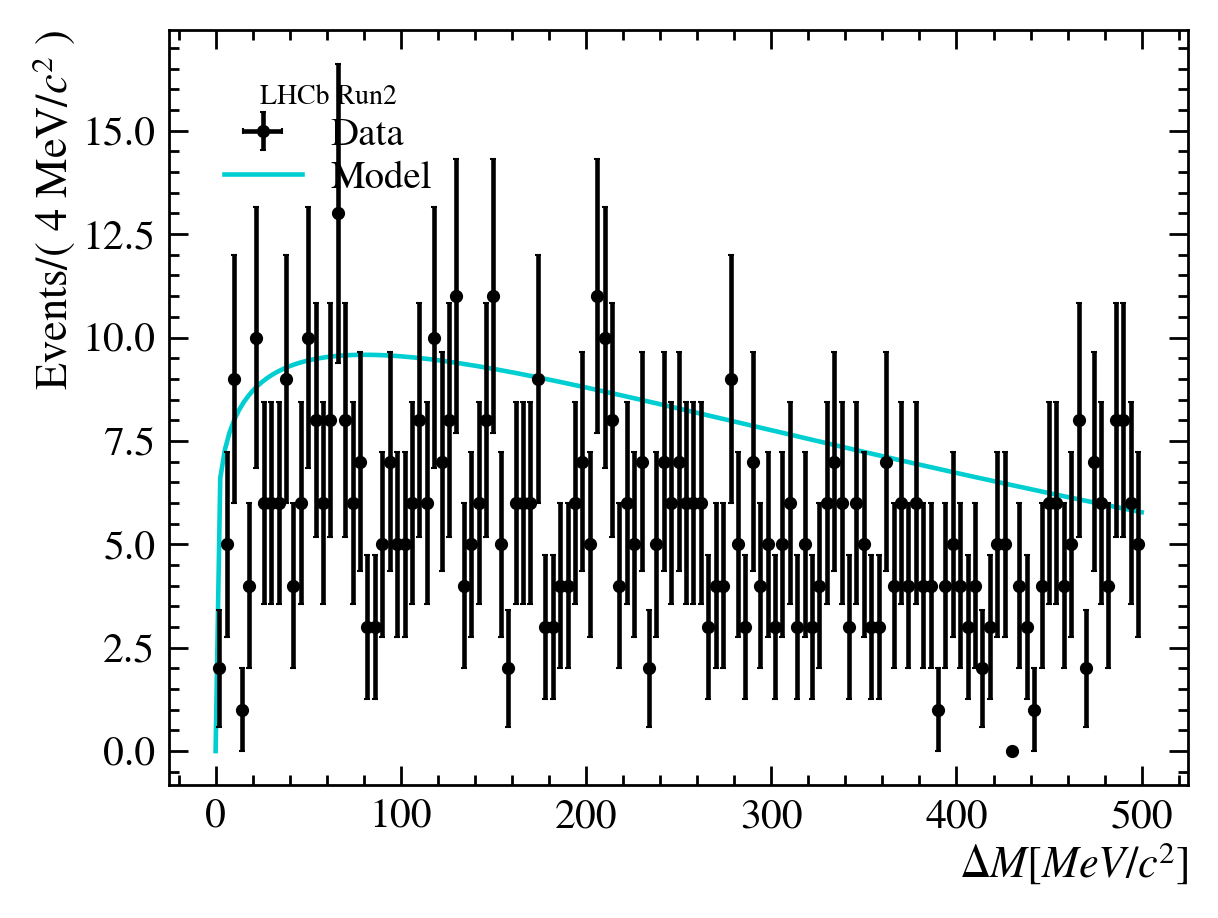

In [24]:
basis_pdf = np.linspace(obs_min, obs_max, 200)
model_pdf_np = model.pdf(basis_pdf).numpy() * (len(data_all))

plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, zmodel=model, title=f'LHCb Run2')

In [25]:
len(data_all)

1001

In [26]:
data_Omega

,C_ETA,C_LOKI_IPCHI2,C_Y,C_ENDVERTEX_X,C_ENDVERTEX_Y,C_ENDVERTEX_Z,C_ENDVERTEX_XERR,C_ENDVERTEX_YERR,C_ENDVERTEX_ZERR,C_ENDVERTEX_CHI2,...,nSPDHits,nMuonCoordsS0,nMuonCoordsS1,nMuonCoordsS2,nMuonCoordsS3,nMuonCoordsS4,nMuonTracks,pidAbnormalType,pidAbnormalTheta,sumCandidates
entry,,,,,,,,,,,,,,,,,,,,,
0,2.382932,0.636094,2.272931,0.732811,-0.125293,-10.728357,0.185340,0.045954,1.016733,0.150825,...,362,383,178,56,4,18,0,0,10.0,1
1,4.009636,3.318250,3.783685,0.856790,-0.046570,-17.849529,0.095987,0.435337,12.123476,0.036476,...,238,260,43,9,0,4,2,0,10.0,1
2,3.001131,0.073094,2.915801,0.842984,-0.130715,45.216154,0.061314,0.142420,1.545359,0.514652,...,186,200,18,13,2,3,1,0,10.0,1
3,3.266724,0.842624,3.113436,0.734167,-0.224063,-2.700462,0.328326,0.012625,4.306541,2.637602,...,258,254,61,8,4,6,4,0,10.0,1
4,3.726498,0.397843,3.680371,0.821658,-0.209805,4.722823,0.379959,0.411499,11.543663,0.152700,...,200,226,21,12,1,5,0,0,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,2.982206,0.282884,2.883482,0.819575,0.185524,-87.307657,0.065917,0.026329,0.671656,1.279804,...,260,240,85,6,3,13,1,0,10.0,1
5873,2.544501,0.229261,2.489718,0.839881,0.132412,-55.160816,0.054803,0.095562,0.690724,2.280052,...,319,376,49,5,2,5,2,0,10.0,1
5874,3.257829,0.321394,3.242583,0.861674,0.182473,-32.399282,0.078243,0.052300,1.218152,0.262447,...,220,204,129,10,1,2,1,0,10.0,1
